### Ridge Regression VAR

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

import helper.helper as h

### Generate Data

[[ 0.   0.   0.   0.   0. ]
 [ 0.6  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   1.2  0.   0. ]
 [-0.6  0.   1.4  0.   0.9]]


(84,
 array([[ 0.04210037,  0.00660027, -0.23454133,  0.04222599, -0.07787657],
        [ 0.3278613 ,  0.03648732,  0.10813912, -0.00798205,  0.02442158],
        [-0.14516518,  0.02918955,  0.27870163,  0.03022082,  0.12328638],
        [ 0.00403426, -0.00793096,  0.61488492, -0.04232183,  0.03215525],
        [-0.30579521, -0.01638219,  0.79910184,  0.04241109,  0.6513697 ]]),
 [4.374790239022608,
  4.382413006469895,
  4.378985853526214,
  4.376615351721326,
  4.375236942703918,
  4.374790239022608,
  4.3752187158078,
  4.376469428629992,
  4.378492755009151,
  4.381242157323034,
  4.384673965102799,
  4.388747174916189,
  4.393423266226007,
  4.398666031777179,
  4.4044414212125975,
  4.410717396748275,
  4.4174637998541755,
  4.424652227990251,
  4.432255920539157,
  4.44024965315925,
  4.448609639854825,
  4.45731344212635,
  4.466339884622281,
  4.475668976766998,
  4.485281839886867,
  4.495160639399272,
  4.505288521667894,
  4.515649555162347,
  4.526228675591647,
  4.5370116

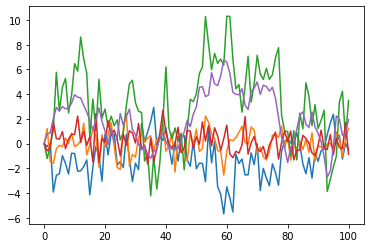

In [317]:
T, p, s = 101, 5, 5

A_true = h.generate_A(p, s)
print(np.round(A_true, 1))
X = h.generate_var_2(T, p, A_true, np.identity(p))
plt.plot(X)

find_lambda(A_true, X, 1)

### OLS and ridge regression

In [318]:
# least squares
A_OLS = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:]
print(f"A_OLS:\n{np.round(A_OLS, 1)}.")

# ridge
lam = 1000
print(f"A_{lam}:\n{np.round(np.linalg.inv(X[:-1].T @ X[:-1] + lam * np.identity(p)) @ X[:-1].T @ X[1:], 1)}.")

A_OLS:
[[-0.1  0.  -0.2  0.1  0. ]
 [ 0.7  0.1  0.1 -0.   0. ]
 [-0.1  0.   0.1  0.  -0.1]
 [-0.  -0.   1.3 -0.1  0. ]
 [-0.5 -0.   1.2  0.1  1.1]].
A_1000:
[[ 0.1  0.  -0.2  0.  -0.1]
 [ 0.1  0.   0.  -0.   0. ]
 [-0.2  0.   0.4  0.   0.2]
 [-0.  -0.   0.1 -0.   0. ]
 [-0.1  0.   0.4  0.   0.3]].


### Solution path for $\lambda$

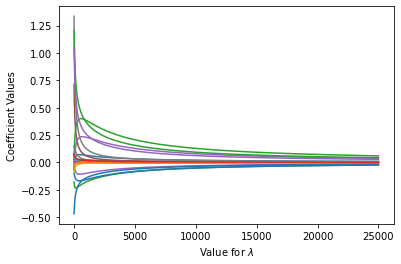

In [319]:
lam_range = np.linspace(0, 25000, 1000)
lams, mses = [], []

# for each lambda
for lam in lam_range:
    # compute A_lam, and append its coefficients as a value of lambda
    A_lam = np.linalg.inv(X[:-1].T @ X[:-1] + lam * np.identity(p)) @ X[:-1].T @ X[1:]
    lams.append(A_lam.flatten())
    mses.append(h.MSE(A_lam, X))

# plot lambdas
plt.xlabel(r"Value for $\lambda$")
plt.ylabel("Coefficient Values")
plt.plot(lam_range, lams);

### Expected Cost

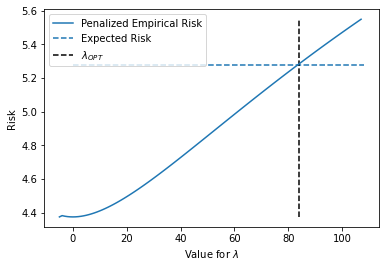

In [322]:
def expected_cost_var(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W_true.T, W_true.T)), Sigma.reshape(p ** 2)).reshape((p, p))
    
    # covariance matrix
    covariance_matrix = Sigma + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

# get true risk, plot as horizontal lines to penalized risk
true_mse = expected_cost_var(A_true, A_OLS)
plt.hlines(true_mse, 0, len(mses) - 5, linestyle = '--', label = "Expected Risk")
plt.vlines(lam, min(mses), max(mses), linestyle = "--", label = "$\lambda_{OPT}$", color = "black")
plt.xlabel("Value for $\lambda$")
plt.ylabel("Risk")
plt.plot(range(-5, len(mses) - 5), mses, label = "Penalized Empirical Risk")
plt.legend()

### Finding $\lambda$

In [321]:
def find_lambda(A_true, X, step_size = 1):
    """Find lambda such that R(fn) + lambda |A| = E[R(fn)]"""
    
    lam = -5
    A = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:]
    true_mse = expected_cost_var(A_true, A)
    mses = [h.MSE(A, X)]
    
    while mses[-1] < true_mse:
        lam += step_size
        A = np.linalg.inv(X[:-1].T @ X[:-1] + lam * np.identity(p)) @ X[:-1].T @ X[1:]
        mse = h.MSE(A, X)
        mses.append(mse)
    
    lam_return = lam 
    
    while mses[-1] < true_mse * 1.05:
        lam += step_size
        A = np.linalg.inv(X[:-1].T @ X[:-1] + lam * np.identity(p)) @ X[:-1].T @ X[1:]
        mse = h.MSE(A, X)
        mses.append(mse)
        
    return lam_return, A, mses

lam, A_lam, mses = find_lambda(A_true, X, 1)
print(f"lambda such that the penalized empirical risk is close to the true risk: {lam}.")
print(f"Corresponding ridge regression A:\n{np.round(A_lam, 1)}.")

lambda such that the penalized empirical risk is close to the true risk: 84.
Corresponding ridge regression A:
[[ 0.   0.  -0.2  0.  -0.1]
 [ 0.3  0.   0.1 -0.   0. ]
 [-0.1  0.   0.3  0.   0.1]
 [ 0.  -0.   0.6 -0.   0. ]
 [-0.3 -0.   0.8  0.   0.7]].
